In [1]:
# Packages for analysis
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Packages for visuals
import matplotlib.pyplot as plt

# Allows charts to appear in the notebook
%matplotlib inline

import pyart
import numpy.ma as ma
import matplotlib.ticker as mticker
from matplotlib import colors as c
from matplotlib.colors import ListedColormap,BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import os
import warnings
import pickle
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:939: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:948: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3

# Make SVM from training datas

In [2]:
model = pickle.load(open("A3/SVM_model_file_b4.pkl", "rb"))

# Make other data test

In [3]:
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape_grid = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def remove_noises(self): #Step 3-A
        mask_noises_CC=ma.masked_less(self.radar.fields['cross_correlation_ratio']['data'],0.85)
        mask_noises_Z=ma.masked_less(self.radar.fields['reflectivity']['data'],0)
        rm_noises_Z_=np.ma.masked_array(self.radar.fields['reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_Z=np.ma.masked_array(rm_noises_Z_,mask_noises_Z.mask)
        rm_noises_ZDR_=np.ma.masked_array(self.radar.fields['differential_reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_ZDR=ma.masked_array(rm_noises_ZDR_,mask_noises_Z.mask)
        self.radar.add_field_like('reflectivity','Z_removed_noises',rm_noises_Z,replace_existing=True)
        self.radar.add_field_like('differential_reflectivity','ZDR_removed_noises', rm_noises_ZDR,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape_grid, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-200000, 200000), (-200000, 200000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['Z_removed_noises',
                    'ZDR_removed_noises',
                    ],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape_grid[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid
    def YH95_algorithm(self,Zh):
        Zh.mask=0
        YH95=np.zeros((self.shape_grid[1],self.shape_grid[2]))
        #Step 1: Intensity
        mask_st1=(Zh>=40)
        YH95[mask_st1]=1
        #Step 2: Peakeness
        def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            Zh_none_O=Zh[xo,yo]
            Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
            Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
            return Zbg
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if YH95[xo,yo]==0:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    deltaZh=Zh[xo,yo]-Zbg
                    if (Zbg < 42.43) and (deltaZh >= (10-Zbg**2/180)):
                        YH95[xo,yo]=1
                    elif Zbg>=42.43 and deltaZh>=0:
                        YH95[xo,yo]=1
        #Step3: Surrounding area
        def MBG_mask_r(xo,yo,n,r,): # mask array with r change
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            return mask
        medium=[25,30,35,40]
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if YH95[xo,yo]==1:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    if Zbg < medium[0]:
                        r=0.5 #1km
                    elif Zbg>=medium[0] and Zbg <medium[1]:
                        r=1   #2km
                    elif Zbg>=medium[1] and Zbg <medium[2]: 
                        r=1.5 #3km
                    elif Zbg>=medium[2] and Zbg <medium[3]:
                        r=2   #4km
                    elif Zbg>=medium[3]:
                        r=2.5 #5km
                    mask_st2=MBG_mask_r(xo,yo,self.shape_grid[1],r=r)
                    YH95[mask_st2]=2
        #Step4: remaining ares as stratiform
        for q in range (0,self.shape_grid[1],1):
            for l in range (0,self.shape_grid[2],1):
                if Zh[q,l] > 0 and YH95[q,l] !=2:
                    YH95[q,l]=1
        return YH95
#Tạo giới hạn bán kính 200km    
y,x = np.ogrid[-100:201-100, -100:201-100]
mask = x*x + y*y > 100*100

In [246]:
linkRAW="D:/data/Radars/Embedded/6/"
#"C:/Users/Admin/Desktop/Practice SVM/Frequency/6 events datas/Full stratiform/"
filename="PHA210707192004.RAWK6CC"

In [247]:
radar = pyart.io.read_sigmet(linkRAW+filename)
lat_0 = radar.latitude['data'][0]
lon_0 = radar.longitude['data'][0]
shape_grid = (7, 201,201)
UF_File = UF(radar, shape_grid, lat_0, lon_0)
UF_File.remove_noises()
grid = UF_File.convert_grid()
grid_lat_lon = UF_File.convert_lat_lon(grid)
SHY95=np.ma.masked_array(ma.masked_equal(UF_File.YH95_algorithm(grid.fields['Z_removed_noises']['data'][1,:,:]),0.0),mask)
Zh_SVM=np.ma.masked_array(ma.masked_equal(grid.fields['Z_removed_noises']['data'][1,:,:],0.0),mask)
ZDR_SVM=np.ma.masked_array(grid.fields['ZDR_removed_noises']['data'][1,:,:],mask)

In [248]:
SVM=np.zeros((shape_grid[1],shape_grid[2]))
for xo in range (0,shape_grid[1],1):
    for yo in range (0,shape_grid[2],1):
        if Zh_SVM[xo,yo]!='masked' and ZDR_SVM[xo,yo]!='masked':
            resuls=model.predict([[Zh_SVM[xo,yo], ZDR_SVM[xo,yo]]])
            if resuls==2.0:
                SVM[xo,yo]=2
            elif resuls==1.0:
                SVM[xo,yo]=1
SVM=ma.masked_equal(SVM,0)

In [249]:
shape_grid = (181, 201,201)
UF_File = UF(radar, shape_grid, lat_0, lon_0)
ref_cor_noise=UF_File.remove_noises()
grid2 = UF_File.convert_grid()
display = pyart.graph.GridMapDisplay(grid2)
Zh_max=grid2.fields['Z_removed_noises']['data']
Zh_max=ma.masked_less_equal(np.amax(Zh_max,axis=0),0.)

# Plot resuls of SHY95 and SVM

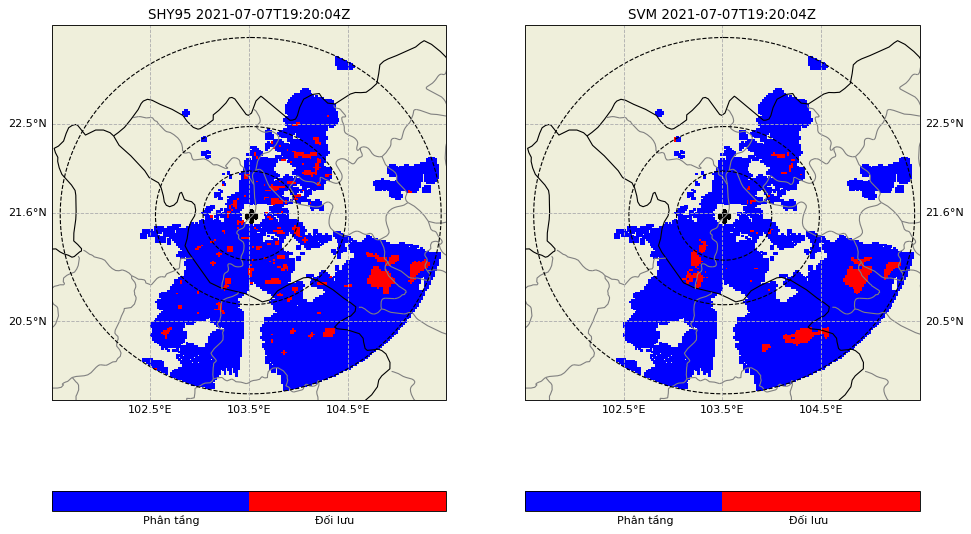

In [250]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=radar.longitude['data'][0],lat=radar.latitude['data'][0], radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=radar.longitude['data'][0],lat=radar.latitude['data'][0], radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=radar.longitude['data'][0],lat=radar.latitude['data'][0], radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
#plot map with datas
fig=plt.figure(figsize=(14,22),dpi=80)
ax1=fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlocator = mticker.FixedLocator([101.5,102.5, round(grid.x['data'][100],1), 104.5, 105.5])
g1.ylocator = mticker.FixedLocator([19.5,20.5,round(grid.y['data'][100],1),22.5, 23.5])
ax1.set_extent((101.5,105.5,19.7,23.5),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
cMap = c.ListedColormap(['blue','red'])
lon=grid_lat_lon.x['data']
lat=grid_lat_lon.y['data']
lons,lats=np.meshgrid(lon,lat)
z1_plot=ax1.pcolormesh(lons,lats,SHY95,shading='flat',cmap=cMap)#cmap=cmap,norm=norm)
ax1.scatter(x=radar.longitude['data'][0],y=radar.latitude['data'][0],transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P')
ax1.set(title="SHY95 "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal',ticks=[], label='Phân tầng                                 Đối lưu')

ax2=fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax2.add_feature(cfeat.LAND)
ax2.add_feature(cfeat.OCEAN.with_scale('10m'))
ax2.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax2.add_feature(state_provinces_lines,edgecolor='gray')
g2=ax2.gridlines(draw_labels=True,linestyle='--')
g2.xlabels_top = False
g2.ylabels_left = False
g2.xlocator = mticker.FixedLocator([101.5,102.5, round(grid.x['data'][100],1), 104.5, 105.5])
g2.ylocator = mticker.FixedLocator([19.5,20.5,round(grid.y['data'][100],1),22.5, 23.5])
ax2.set_extent((101.5,105.5,19.7,23.5),crs=ccrs.PlateCarree())
ax2.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
z2_plot=ax2.pcolormesh(lons,lats,SVM,shading='flat',cmap=cMap)
ax2.scatter(x=radar.longitude['data'][0],y=radar.latitude['data'][0],transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P');
ax2.set(title="SVM " +radar.time['units'][14:] )
plt.colorbar(z2_plot,ax=ax2,orientation='horizontal',ticks=[], label='Phân tầng                                 Đối lưu');

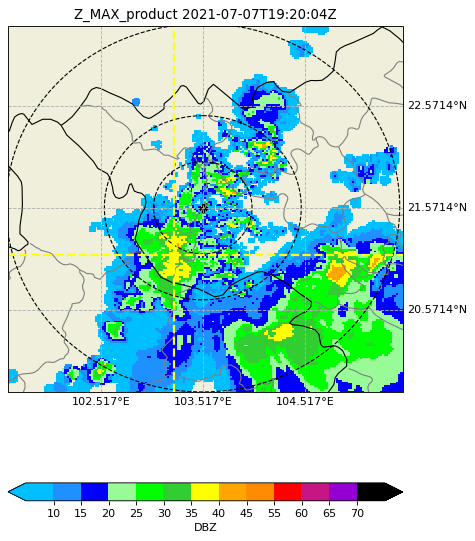

In [333]:
cmap=ListedColormap(['deepskyblue', 'dodgerblue','blue', 'palegreen','lime','limegreen','yellow','orange','darkorange','red','mediumvioletred','darkviolet','black'])
bounds=[0,10,15,20,25,30,35,40,45,55,60,65,70,80]
norm = BoundaryNorm(bounds, cmap.N)
ticks  = [10,15,20,25,30,35,40,45,55,60,65,70]
circle_points_50km= cargeo.Geodesic().circle(lon=103.51694002747536,lat=21.571390070021152, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.51694002747536,lat=21.571390070021152, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.51694002747536,lat=21.571390070021152, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
#plot map with datas
lat= 21.11
lon= 103.233
fig=plt.figure(figsize=(14,22),dpi=80)
ax1=fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((grid.x['data'][0],grid.x['data'][-1],grid.y['data'][0],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
z1_plot=ax1.pcolormesh(lons,lats,Zh_max,shading='flat',cmap=cmap,norm=norm)#cmap=cmap,norm=norm)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
#ax1.scatter(x=105.2796,y=21.16711,transform=ccrs.PlateCarree(), color="red",s=100, alpha=1,marker='o')
ax1.axhline(lat, linestyle='--', color='#FFFF14',linewidth=2)
ax1.axvline(lon,linestyle='--', color='#FFFF14',linewidth=2)
#ny_lon, ny_lat = 102.5, 21.5
#delhi_lon, delhi_lat = 104.5, 21.5
#ax1.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],color='red', linestyle='--',transform=ccrs.PlateCarree())
ax1.set(title="Z_MAX_product "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,ticks=ticks,extend='both',label="DBZ",orientation='horizontal');

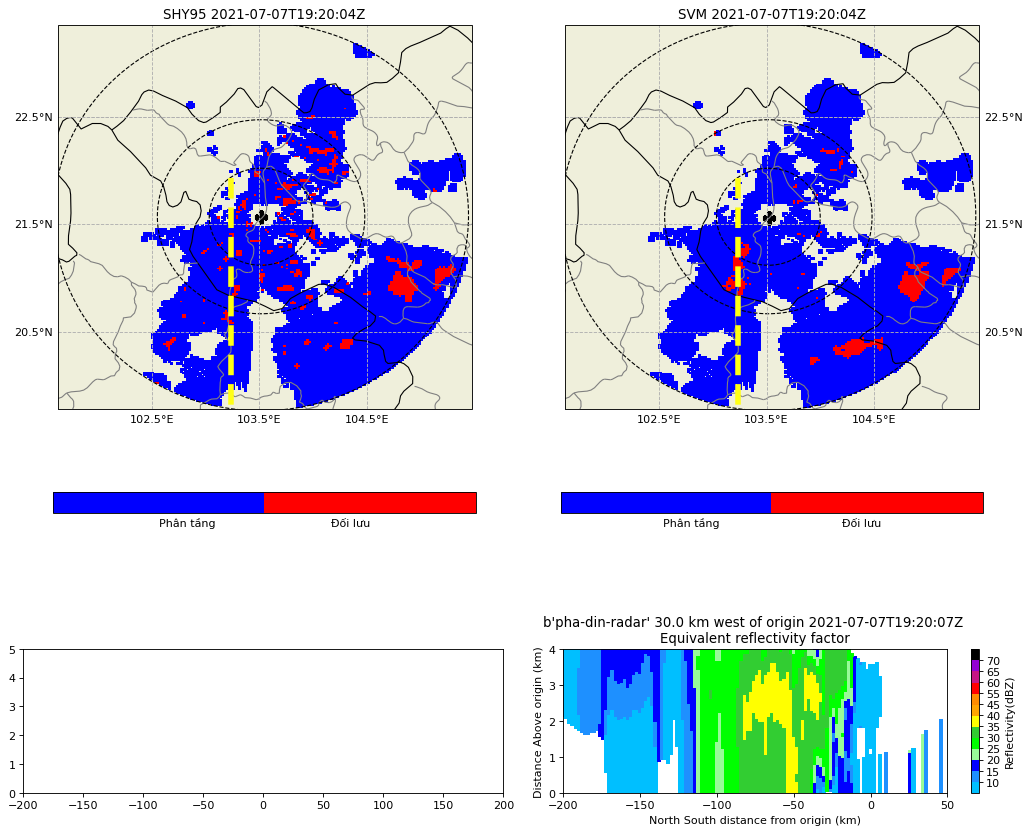

In [350]:
fig=plt.figure(figsize=(15,20),dpi=80)
ax1=fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlocator = mticker.FixedLocator([102.5, 103.5, 104.5, 105.5])
g1.ylocator = mticker.FixedLocator([20.5,21.5,22.5, 22.5])
ax1.set_extent((grid.x['data'][1],grid.x['data'][-1],grid.y['data'][1],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
cMap = c.ListedColormap(['b','r'])
z1_plot=ax1.pcolormesh(lons,lats,SHY95,shading='flat',cmap=cMap)#cmap=cmap,norm=norm)
ax1.scatter(x=radar.longitude['data'][0],y=radar.latitude['data'][0],transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P')
ax1.set(title="SHY95 "+ radar.time['units'][14:])
#lat = 21.971 ok
#ax1.axhline(lat, linestyle='--', color='#FFFF14',linewidth=3)
#ax1.axvline(lon,linestyle='--', color='#FFFF14',linewidth=3)
ny_lon, ny_lat = lon, 19.0
delhi_lon, delhi_lat = lon, 22.0
ax1.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],color='#FFFF14', linestyle='--',transform=ccrs.PlateCarree(),linewidth=5)
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal',ticks=[], label='Phân tầng                                 Đối lưu')

ax2=fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax2.add_feature(cfeat.LAND)
ax2.add_feature(cfeat.OCEAN.with_scale('10m'))
ax2.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax2.add_feature(state_provinces_lines,edgecolor='gray')
g2=ax2.gridlines(draw_labels=True,linestyle='--')
g2.xlabels_top = False
g2.ylabels_left = False
g2.xlocator = mticker.FixedLocator([102.5, 103.5, 104.5, 105.5])
g2.ylocator = mticker.FixedLocator([20.5,21.5,22.5, 22.5])
ax2.set_extent((grid.x['data'][1],grid.x['data'][-1],grid.y['data'][1],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax2.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
z2_plot=ax2.pcolormesh(lons,lats,SVM,shading='flat',cmap=cMap)
ax2.scatter(x=103.526,y=21.5632,transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P');
ax2.set(title="SVM " +radar.time['units'][14:] )
#ax2.axhline(lat, linestyle='--', color='#FFFF14',linewidth=3)
#ax2.axvline(lon,linestyle='--', color='#FFFF14',linewidth=3)
ax2.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],color='#FFFF14', linestyle='--',transform=ccrs.PlateCarree(),linewidth=5)
plt.colorbar(z2_plot,ax=ax2,orientation='horizontal',ticks=[], label='Phân tầng                                   Đối lưu');

x_cut_panel_axes = [0.55, 0.4, .4, .09] #Đường cắt nằm dọc (Hình 4) - lon
ax3=fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('Z_removed_noises',lon=lon, lat=lat, cmap=cmap,norm=norm,ticks=ticks,label="DBZ")
display.label='DBZ'
ax3.set_ylim([0, 4])
ax3.set_xlim([-200, 50])

y_cut_panel_axes = [0.1, 0.4, .4, .09] #Đường cẳt nằm ngang (Hình 3)-  lat
ax4 = fig.add_axes(y_cut_panel_axes)
#display.plot_latitude_slice('Z_removed_noises', lon=lon, lat=lat,cmap=cmap,norm=norm,ticks=ticks,label="DBZ")
ax4.set_ylim([0, 5])
ax4.set_xlim([-200, 200]);


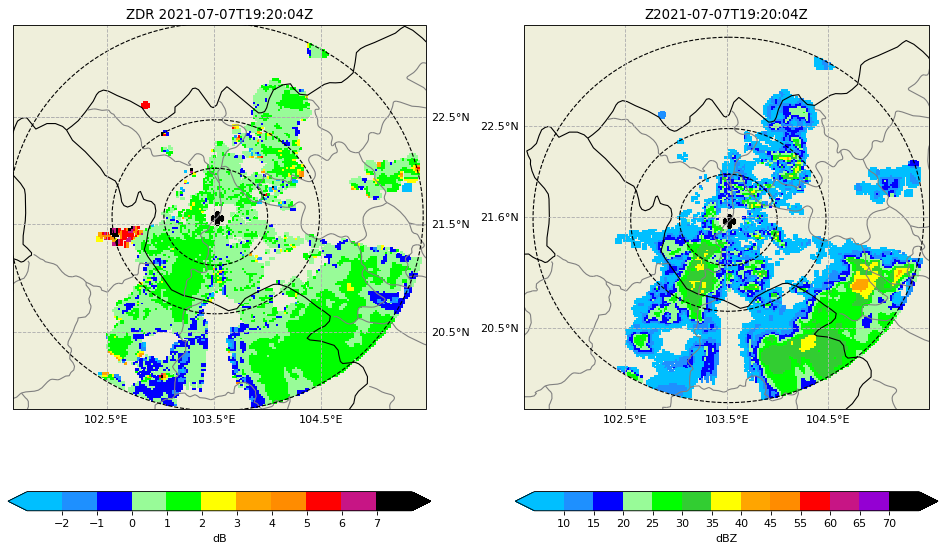

In [332]:
#plot map with datas
cmap2=ListedColormap(['deepskyblue', 'dodgerblue','blue', 'palegreen','lime','limegreen','yellow','orange','darkorange','red','mediumvioletred','darkviolet','black'])
bounds2=[-3,-2,-1,0,1,2,3,4,5,6,7,8]
norm2 = BoundaryNorm(bounds2, cmap2.N)
ticks2  = [-2,-1,0,1,2,3,4,5,6,7]
fig=plt.figure(figsize=(15,20),dpi=80)
ax1=fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.5, 103.5, 104.5, 105.5])
g1.ylocator = mticker.FixedLocator([20.5,21.5,22.5, 22.5])
ax1.set_extent((grid.x['data'][1],grid.x['data'][-1],grid.y['data'][1],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
z1_plot=ax1.pcolormesh(lons,lats,ZDR_SVM,shading='flat',cmap=cmap2,norm=norm2)#cmap=pyart.graph.cm.NWSRef, vmax=11,vmin=-5)#cmap=cmap,norm=norm)
ax1.scatter(x=103.526,y=21.5632,transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P')
ax1.set(title="ZDR "+ radar.time['units'][14:])
plt.colorbar(z1_plot,ax=ax1,orientation='horizontal',label="dB",extend='both',ticks=ticks2 )

cmap=ListedColormap(['deepskyblue', 'dodgerblue','blue', 'palegreen','lime','limegreen','yellow','orange','darkorange','red','mediumvioletred','darkviolet','black'])
bounds=[0,10,15,20,25,30,35,40,45,55,60,65,70,80]
norm = BoundaryNorm(bounds, cmap.N)
ticks  = [10,15,20,25,30,35,40,45,55,60,65,70]
ax2=fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax2.add_feature(cfeat.LAND)
ax2.add_feature(cfeat.OCEAN.with_scale('10m'))
ax2.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax2.add_feature(state_provinces_lines,edgecolor='gray')
g2=ax2.gridlines(draw_labels=True,linestyle='--')
g2.xlabels_top = False
g2.ylabels_right = False
g2.xlocator = mticker.FixedLocator([101.5,102.5, round(grid.x['data'][100],1), 104.5, 105.5])
g2.ylocator = mticker.FixedLocator([19.5,20.5,round(grid.y['data'][100],1),22.5, 23.5])
ax2.set_extent((101.5,105.5,19.7,23.5),crs=ccrs.PlateCarree())
ax2.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax2.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
z2_plot=ax2.pcolormesh(lons,lats,Zh_SVM,shading='flat',cmap=cmap,norm=norm)
ax2.scatter(x=103.526,y=21.5632,transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P')
ax2.set(title="Z"+ radar.time['units'][14:])
plt.colorbar(z2_plot,ax=ax2,ticks=ticks,extend='both',label="dBZ",orientation='horizontal')
